In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Tuple, List, Dict, Any
from pathlib import Path
import jax
import jax.numpy as jnp
from jax import random, Array
from tqdm.auto import tqdm
import equinox as eqx
from pprint import pprint
#set seeds
np.random.seed(42)
n_runs = 2000
n_exps = 500


In [2]:
df = pd.read_csv("data/japan_n_skorea.csv")
df = df[["time", "mag"]]

results_table = {}


# Auxiliary Functions

In [3]:
def save_fig(fig, name)-> None:
    """
    Save the figure to the specified path.
    
    :param name: A string representing the name of the figure.
    :param fig: A matplotlib figure object.
    :return: None
    """
    cwd = Path.cwd()
    path = cwd / "figures" / f"{name}.png"
    if not path.parent.exists(): path.parent.mkdir(parents=True)
    fig.savefig(path)
    
    
    
def calculate_CI(arr: Array, alpha: float = 0.05) -> Tuple[float, float]:
    """
    Calculate the confidence interval of the data.
    
    :param arr: A numpy array of data.
    :param alpha: A float representing the significance level.
    :return: A tuple of the lower and upper bounds of the confidence interval.
    """
    n = len(arr)
    mean = jnp.mean(arr)
    std = jnp.std(arr)
    z = stats.norm.ppf(1 - alpha / 2)
    lower = mean - z * std / jnp.sqrt(n)
    upper = mean + z * std / jnp.sqrt(n)
    return lower, upper
    
    
def calculate_summary(arr: Array) -> Dict[str, float]:
    """
    Calculate the summary statistics of the data.
    
    :param arr: A numpy array of data.
    :param CI: A tuple of the lower and upper bounds of the confidence interval.
    :return: A dictionary of summary statistics.
    """
    CI = calculate_CI(arr)
    return {
        "mean": jnp.mean(arr),
        "std": jnp.std(arr),
        "CI_lower": CI[0],
        "CI_upper": CI[1]
    }

    


# Data Preparation Functions

In [4]:
  

def time_difference(time: pd.Series) -> pd.Series:
    """
    Calculate the time difference between the current time and the next time.
    
    :param time: A pandas Series of datetime values.
    :return: A pandas Series of time differences.
    """
    time_diff = time - time.shift(1)
    return time_diff

def process_time(df) -> pd.Series:
    """
    Process the time series data by converting to datetime, sorting, and calculating time differences.
    
    :param time: A pandas Series of datetime values.
    :return: A pandas Series of time differences in seconds.
    """
    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values("time")
    df["time"] = time_difference(df["time"])
    df["time"] = df["time"].dt.total_seconds()
    df = df[df["time"] > 0].reset_index(drop=True)
    
    return df

# Distribution Analysis

In [5]:


def analyze_distributions(in_series: pd.Series, significance: float = 0.05) -> Tuple[List[List[Any]], Dict[str, Dict[str, float]]]:
    """
    Analyze the distribution of the data and test for goodness of fit.
    
    :param in_series: A pandas Series of time differences.
    :param significance: Significance level for the goodness of fit tests.
    :return: A tuple containing the results of the analysis and the output parameters.
    """
    results = []
    output_parameters = {}

    # Uniform distribution
    fit_uniform_dist = stats.uniform(loc=(in_series.min()), scale=in_series.max() - in_series.min())
    test = stats.kstest(in_series, fit_uniform_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Uniform Distribution", fit_status, p_value])
    output_parameters["Uniform Distribution"] = {
        "loc": in_series.min(),
        "scale": in_series.max() - in_series.min()
    }

    # Exponential distribution
    m1 = np.mean(in_series)
    fit_exponential_dist = stats.expon(scale=1 / m1)
    test = stats.kstest(in_series, fit_exponential_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Exponential Distribution", fit_status, p_value])
    output_parameters["Exponential Distribution"] = {
        "estimated_lambda": 1 / m1
    }

    # Gamma distribution
    m2 = np.mean([x ** 2 for x in in_series])
    est_beta = m1 / (m2 - m1 ** 2)
    est_alpha = m1 * est_beta
    fit_gamma_dist = stats.gamma(a=est_alpha, scale=1 / est_beta)
    test = stats.kstest(in_series, fit_gamma_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Gamma Distribution", fit_status, p_value])
    output_parameters["Gamma Distribution"] = {
        "estimated_alpha": est_alpha,
        "estimated_beta": est_beta
    }

    # Poisson distribution
    fi_poisson_dist = stats.poisson(mu=m1)
    test = stats.kstest(in_series, fi_poisson_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Poisson Distribution", fit_status, p_value])
    output_parameters["Poisson Distribution"] = {
        "estimated_lambda": m1
    }

    # Normal distribution
    estimated_std = m2 - m1 ** 2
    fit_normal_dist = stats.norm(loc=m1, scale=estimated_std)
    test = stats.kstest(in_series, fit_normal_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Normal Distribution", fit_status, np.format_float_scientific(test[1], precision=2)])
    output_parameters["Normal Distribution"] = {
        "estimated_mean": m1,
        "estimated_std": estimated_std
    }
    return results, output_parameters

# Plotting Functions

In [6]:

    

def generate_qq_plot(in_series: pd.Series, output_parameters: Dict[str, Dict[str, float]], case: str,
                               title: str) -> None:
    """
    Generate a Q-Q plot of the data against the fitted distribution.
    :param in_series: input time series data
    :param output_parameters: parameters of the fitted distributions
    :param case: A string representing the case of earthquakes to analyze.
    :param title: A string representing the title of the plot.
    :return:
    """

    uniform_dist = stats.uniform(loc=output_parameters["Uniform Distribution"]["loc"],
                                 scale=output_parameters["Uniform Distribution"]["scale"])
    exp_dist = stats.expon(scale=1 / output_parameters["Exponential Distribution"]["estimated_lambda"])
    gamma_dist = stats.gamma(a=output_parameters["Gamma Distribution"]["estimated_alpha"],
                             scale=1 / output_parameters["Gamma Distribution"]["estimated_beta"])
    poisson_dist = stats.poisson(mu=output_parameters["Poisson Distribution"]["estimated_lambda"])
    normal_dist = stats.norm(loc=output_parameters["Normal Distribution"]["estimated_mean"],
                             scale=output_parameters["Normal Distribution"]["estimated_std"])

    distributions = [exp_dist, gamma_dist, normal_dist, poisson_dist, uniform_dist]
    names = ["Exponential", "Gamma", "Normal", "Poisson", "Uniform"]
    fig, ax = plt.subplots(nrows=len(distributions), ncols=1, figsize=(10, 5 * (len(distributions) + 1)))
    for i, dist in enumerate(distributions):
        stats.probplot(in_series, dist=dist, plot=ax[i])
        ax[i].set_title(f"Q-Q Plot of {names[i]}")
        ax[i].set_xlabel(f"Theoretical Quantiles ({names[i]})")
        ax[i].set_ylabel(f"Sample Quantiles")

    plt.suptitle(
        f"{title}",
        fontsize=16
    )
    formatted = title.replace(" ", "_").lower()
    
    save_fig(fig, f"qq_plot_{formatted}")
    # plt.show()


def overlay_distribution_plot(in_series: pd.Series, output_parameters: Dict[str, Dict[str, float]], case: str,
                                        title: str, subtitle:str) -> None:
    """
    Overlay the distribution plots of the fitted distributions and the data.

    :param in_series: A pandas Series of time differences.
    :param output_parameters: A dictionary of output parameters for the fitted distributions.
    :param case: A string representing the case of earthquakes to analyze.
    :param title: A string representing the title of the plot.
    :return: None
    """
    n = len(in_series)
    exp_dist = np.random.exponential(output_parameters["Exponential Distribution"]["estimated_lambda"], n)
    gamma_dist = np.random.gamma(output_parameters["Gamma Distribution"]["estimated_alpha"],
                                 1 / output_parameters["Gamma Distribution"]["estimated_beta"], n)
    normal_dist = np.random.normal(output_parameters["Normal Distribution"]["estimated_mean"],
                                   output_parameters["Normal Distribution"]["estimated_std"], n)
    poisson_dist = np.random.poisson(output_parameters["Poisson Distribution"]["estimated_lambda"], n)
    uniform_dist = np.random.uniform(output_parameters["Uniform Distribution"]["loc"],
                                     output_parameters["Uniform Distribution"]["scale"], n)

    distributions = [exp_dist, gamma_dist, normal_dist, poisson_dist, uniform_dist]
    names = ["Exponential", "Gamma", "Normal", "Poisson", "Uniform"]

    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 25))

    for i, dist in enumerate(distributions):
        sns.histplot(dist, kde=True, ax=ax[i])
        sns.histplot(in_series, kde=True, ax=ax[i])
        ax[i].legend(["Fitted Distribution", "Data"])
        ax[i].set_title(f"{names[i]} Distribution")
        ax[i].set_xlabel(f"{subtitle}")
        ax[i].set_ylabel("Frequency")

    fig.suptitle(
        f"{title}",
        fontsize=16)
    formatted = title.replace(" ", "_").lower()
    
    save_fig(fig, f"overlay_dist_{formatted}")
    # plt.show()
    
    

def plot_earthquake_data(all_eq: np.ndarray, small_eq: np.ndarray, big_eq: np.ndarray, title: str) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    sns.histplot(all_eq, kde=True, ax=ax[0])
    all_CI = calculate_CI(all_eq)
    ax[0].axvline(all_CI[0], color="red", linestyle="--")
    ax[0].axvline(all_CI[1], color="red", linestyle="--")
    ax[0].set_title("All Earthquakes")
    ax[0].set_xlabel("Number of Earthquakes In a Year")
    ax[0].set_ylabel("Frequency")

    sns.histplot(small_eq, kde=True, ax=ax[1])
    small_CI = calculate_CI(small_eq)
    ax[1].axvline(small_CI[0], color="red", linestyle="--")
    ax[1].axvline(small_CI[1], color="red", linestyle="--")
    ax[1].set_title("Small Earthquakes")
    ax[1].set_xlabel("Number of Earthquakes In a Year")
    ax[1].set_ylabel("Frequency")

    sns.histplot(big_eq, kde=True, ax=ax[2])
    big_CI = calculate_CI(big_eq)
    ax[2].axvline(big_CI[0], color="red", linestyle="--")
    ax[2].axvline(big_CI[1], color="red", linestyle="--")
    ax[2].set_title("Big Earthquakes")
    ax[2].set_xlabel("Number of Earthquakes In a Year")
    ax[2].set_ylabel("Frequency")

    fig.suptitle(title)
    formatted = title.replace(" ", "_").lower()
    save_fig(fig, f"simulation_{formatted}")
    plt.show()

# Data Analysis

In [7]:


def big_magnitude_probability(distribution_type: str, max_magnitude: float,
                              distribution_params: Dict[str, Dict[str, float]]) -> float:
    """
    Calculate the probability of a large earthquake occurring.

    :param distribution_type: Type of the distribution.
    :param max_magnitude: Maximum magnitude of the earthquake.
    :param distribution_params: A dictionary of output parameters for the fitted distributions.
    :return: Probability of a large earthquake occurring.
    """
    if distribution_type == "Uniform Distribution":
        return 1 - stats.uniform.cdf(max_magnitude, loc=distribution_params["Uniform Distribution"]["loc"],
                                     scale=distribution_params["Uniform Distribution"]["scale"])
    elif distribution_type == "Exponential Distribution":
        return 1 - stats.expon.cdf(max_magnitude,
                                   scale=1 / distribution_params["Exponential Distribution"]["estimated_lambda"])
    elif distribution_type == "Gamma Distribution":
        return 1 - stats.gamma.cdf(max_magnitude, a=distribution_params["Gamma Distribution"]["estimated_alpha"],
                                   scale=1 / distribution_params["Gamma Distribution"]["estimated_beta"])
    elif distribution_type == "Normal Distribution":
        return 1 - stats.norm.cdf(max_magnitude, loc=distribution_params["Normal Distribution"]["estimated_mean"],
                                  scale=distribution_params["Normal Distribution"]["estimated_std"])
    else:
        return -1


    

def magnitude_analysis(earthquake_data: pd.DataFrame, threshold_magnitude: float = 5) -> Tuple[str, Dict[str, float]]:
    """
     Analyze the magnitude data and determine the best fit distribution and the probability of a large earthquake.

     :param earthquake_data: A pandas DataFrame containing earthquake data.
     :param threshold_magnitude: The threshold magnitude to calculate the probability of a large earthquake.
     """
    results, distribution_params = analyze_distributions(earthquake_data["mag"])
    p_values = np.array([result[2] for result in results])

    best_fit_index = np.argmax(p_values)
    best_fit_distribution = results[best_fit_index]
    probability = big_magnitude_probability(best_fit_distribution[0], threshold_magnitude, distribution_params)

    print(f"The best fit distribution for the magnitude of the earthquakes is {best_fit_distribution[0]} with a p-value of {best_fit_distribution[2]}")
    print(f"The estimated parameters are: {distribution_params[best_fit_distribution[0]]}")
    print(f"The probability of a large earthquake occurring is {probability}")

    qq_mag_title = f"Q-Q Plot of Earthquake Magnitude vs Theoretical Distributions"
    ov_mag_title = f"Overlay of the Distribution Earthquake Magnitude with Theoretical Distributions  "
    generate_qq_plot(earthquake_data["mag"], distribution_params, "Magnitude", qq_mag_title)
    overlay_distribution_plot(earthquake_data["mag"], distribution_params, "Magnitude", ov_mag_title, "Magnitude of Earthquakes")

    return best_fit_distribution[0], distribution_params[best_fit_distribution[0]]




def inter_arrival_time_analysis(data:pd.DataFrame, case:str) -> Tuple[List[List[Any]], Dict[str, Dict[str, float]]]:
    """
    Main function to process time series data, analyze distributions, and plot the results.
    
    :return: A tuple containing the results of the analysis and the output parameters.
    """
    cases = ["All", "Large", "Small"]
    assert case in cases, f"Invalid case. Choose from {cases}"
    
    time = None
    
    if case == "All":
        time = data
    elif case == "Large":
        time = data[data["mag"] > 5]
    elif case == "Small":
        time = data[data["mag"] < 5]
        

    time = process_time(time)
    dt = time["time"]
    results, output_parameters = analyze_distributions(dt)
    overlay_distribution_plot(dt, output_parameters, case, f"Overlay of the Distribution of Time Differences with Theoretical Distributions ({case} Earthquakes)", "Interval Between Earthquakes (Seconds)")
    generate_qq_plot(dt, output_parameters, case, f"Q-Q Plot of Time Differences vs Theoretical Distributions ({case} Earthquakes)")
    
    best_fit_index = np.argmax([x[2] for x in results])
    best_fit_distribution = results[best_fit_index]
    print(f"The best fit distribution for the time differences is {best_fit_distribution[0]} with a p-value of {best_fit_distribution[2]}")
    print(f"The estimated parameters are: {output_parameters[best_fit_distribution[0]]}")
    
    return results, output_parameters






# Hypothesis Testing

The best fit distribution for the time differences is Gamma Distribution with a p-value of 1.9233627608275783e-26
The estimated parameters are: {'estimated_alpha': np.float64(0.49280378256898094), 'estimated_beta': np.float64(2.916316021846717e-06)}


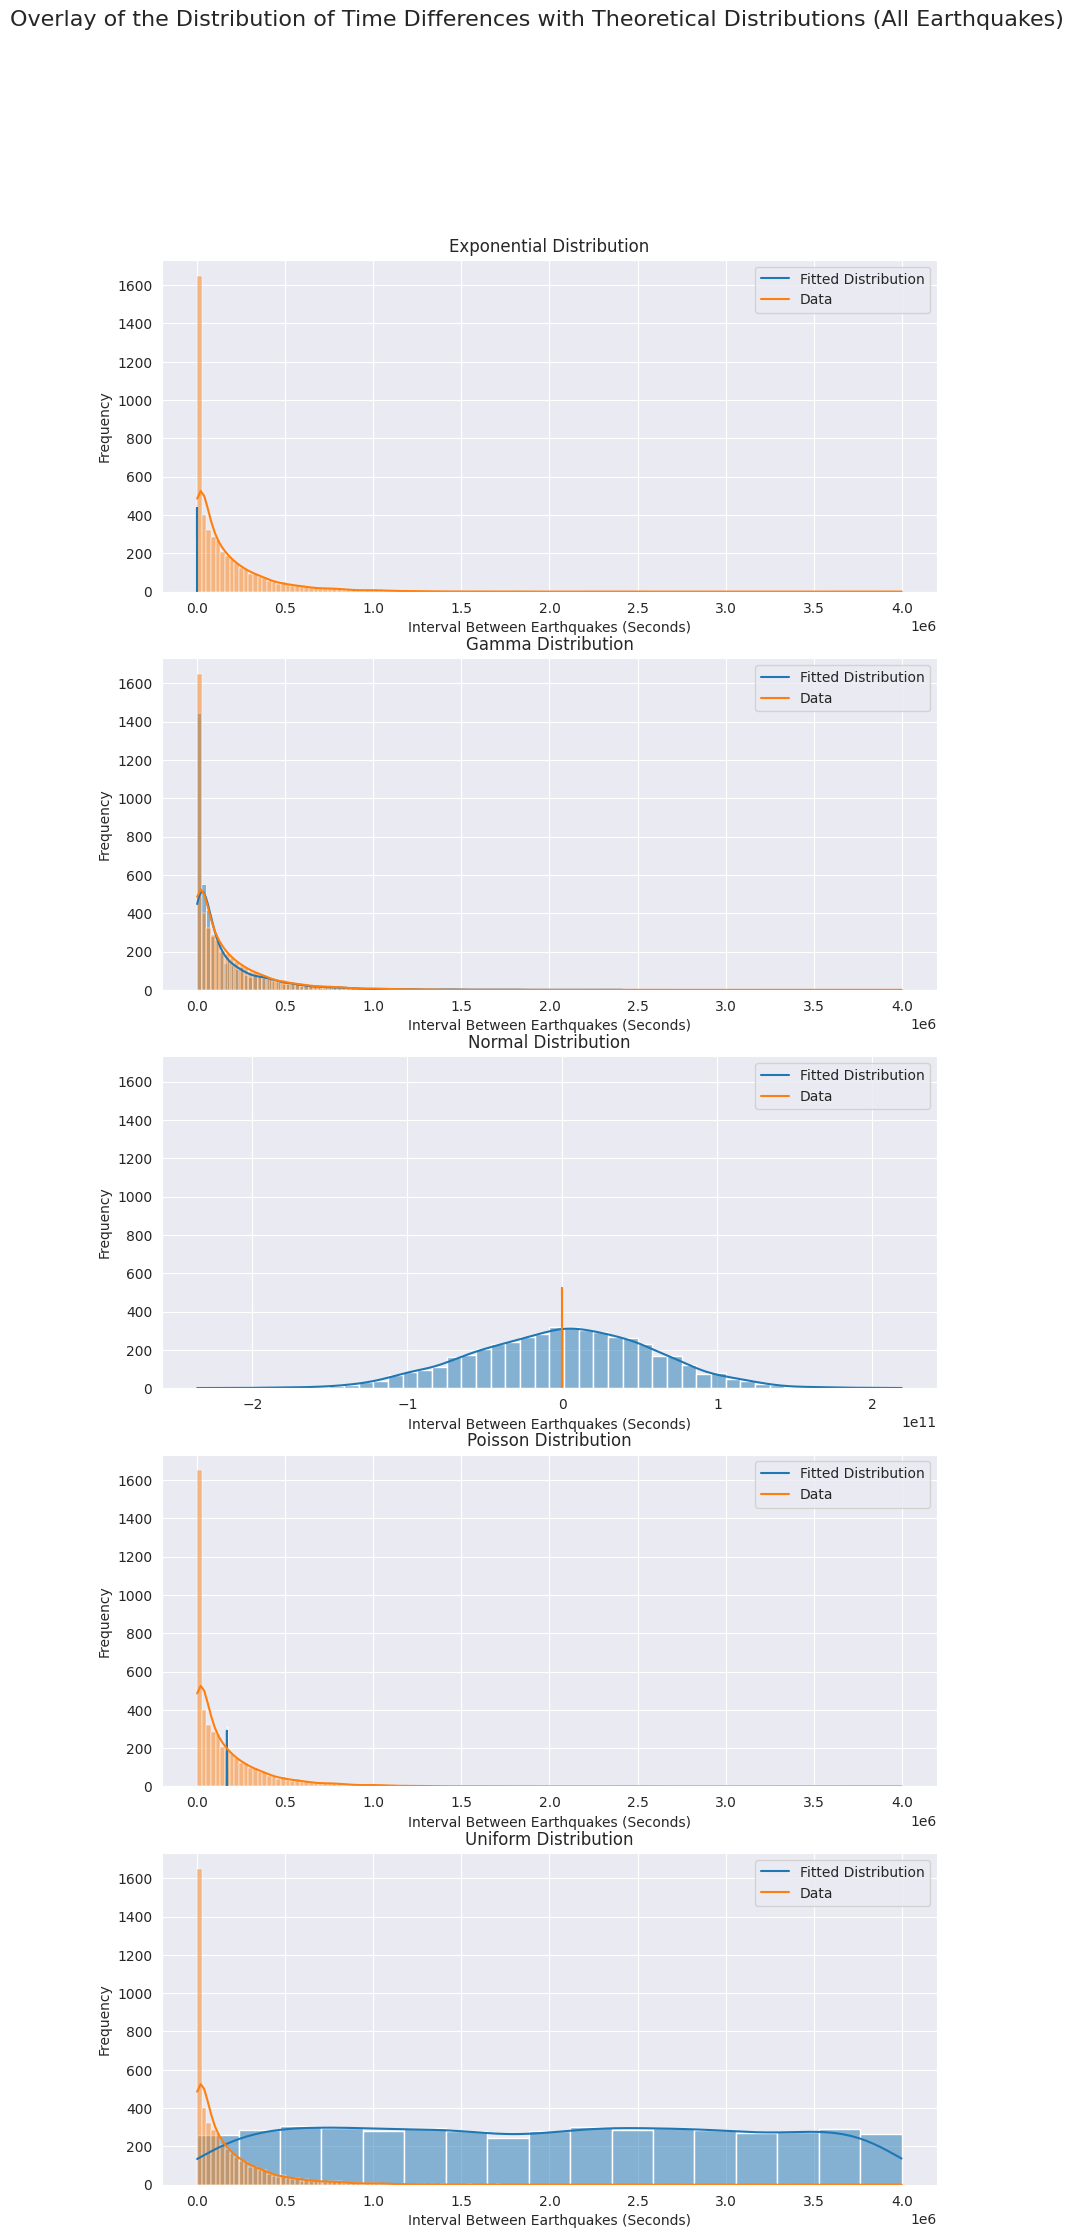

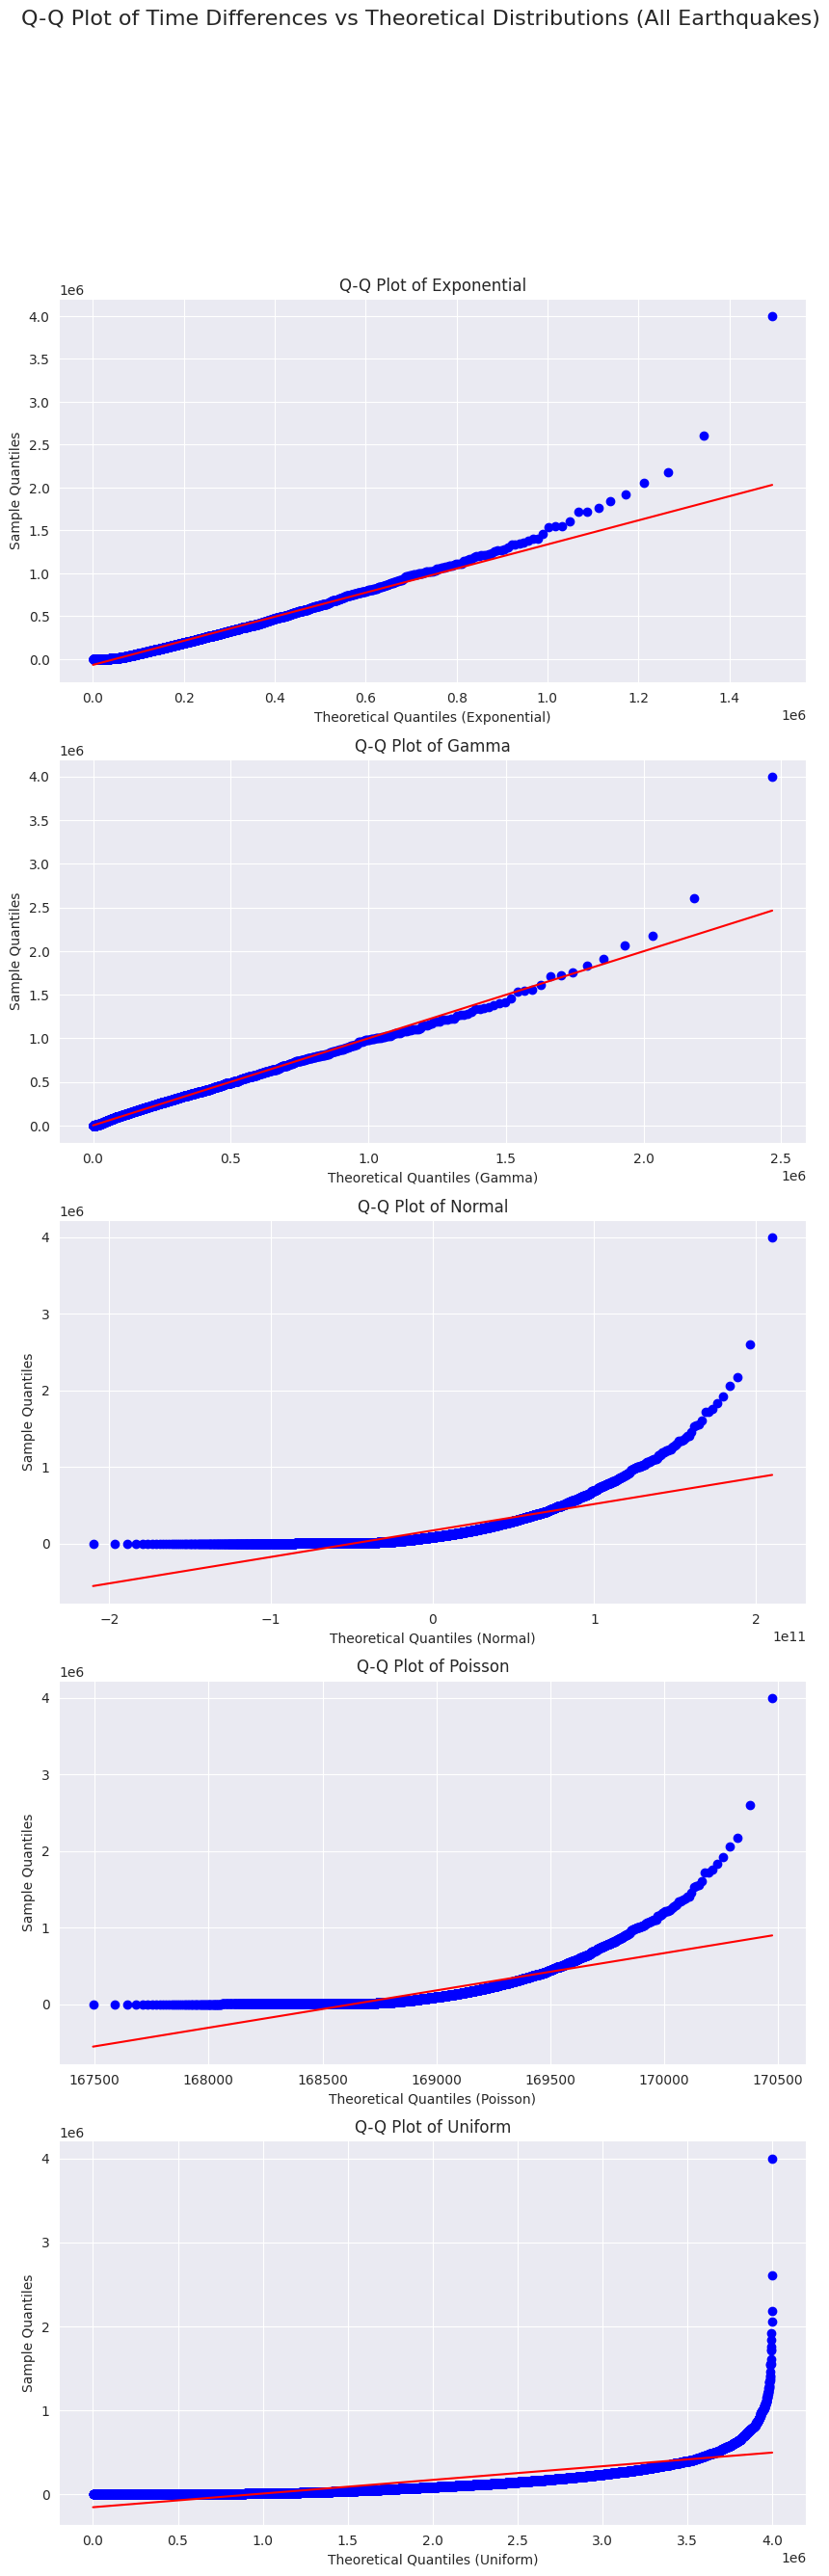

In [8]:

# all earthquake
results_all_eq, params_all_eq = inter_arrival_time_analysis(df, "All")




/tmp/ipykernel_26834/1496985046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_datetime(df["time"])


The best fit distribution for the time differences is Gamma Distribution with a p-value of 9.345310701027074e-06
The estimated parameters are: {'estimated_alpha': np.float64(0.46443239620301113), 'estimated_beta': np.float64(2.080760930963378e-07)}


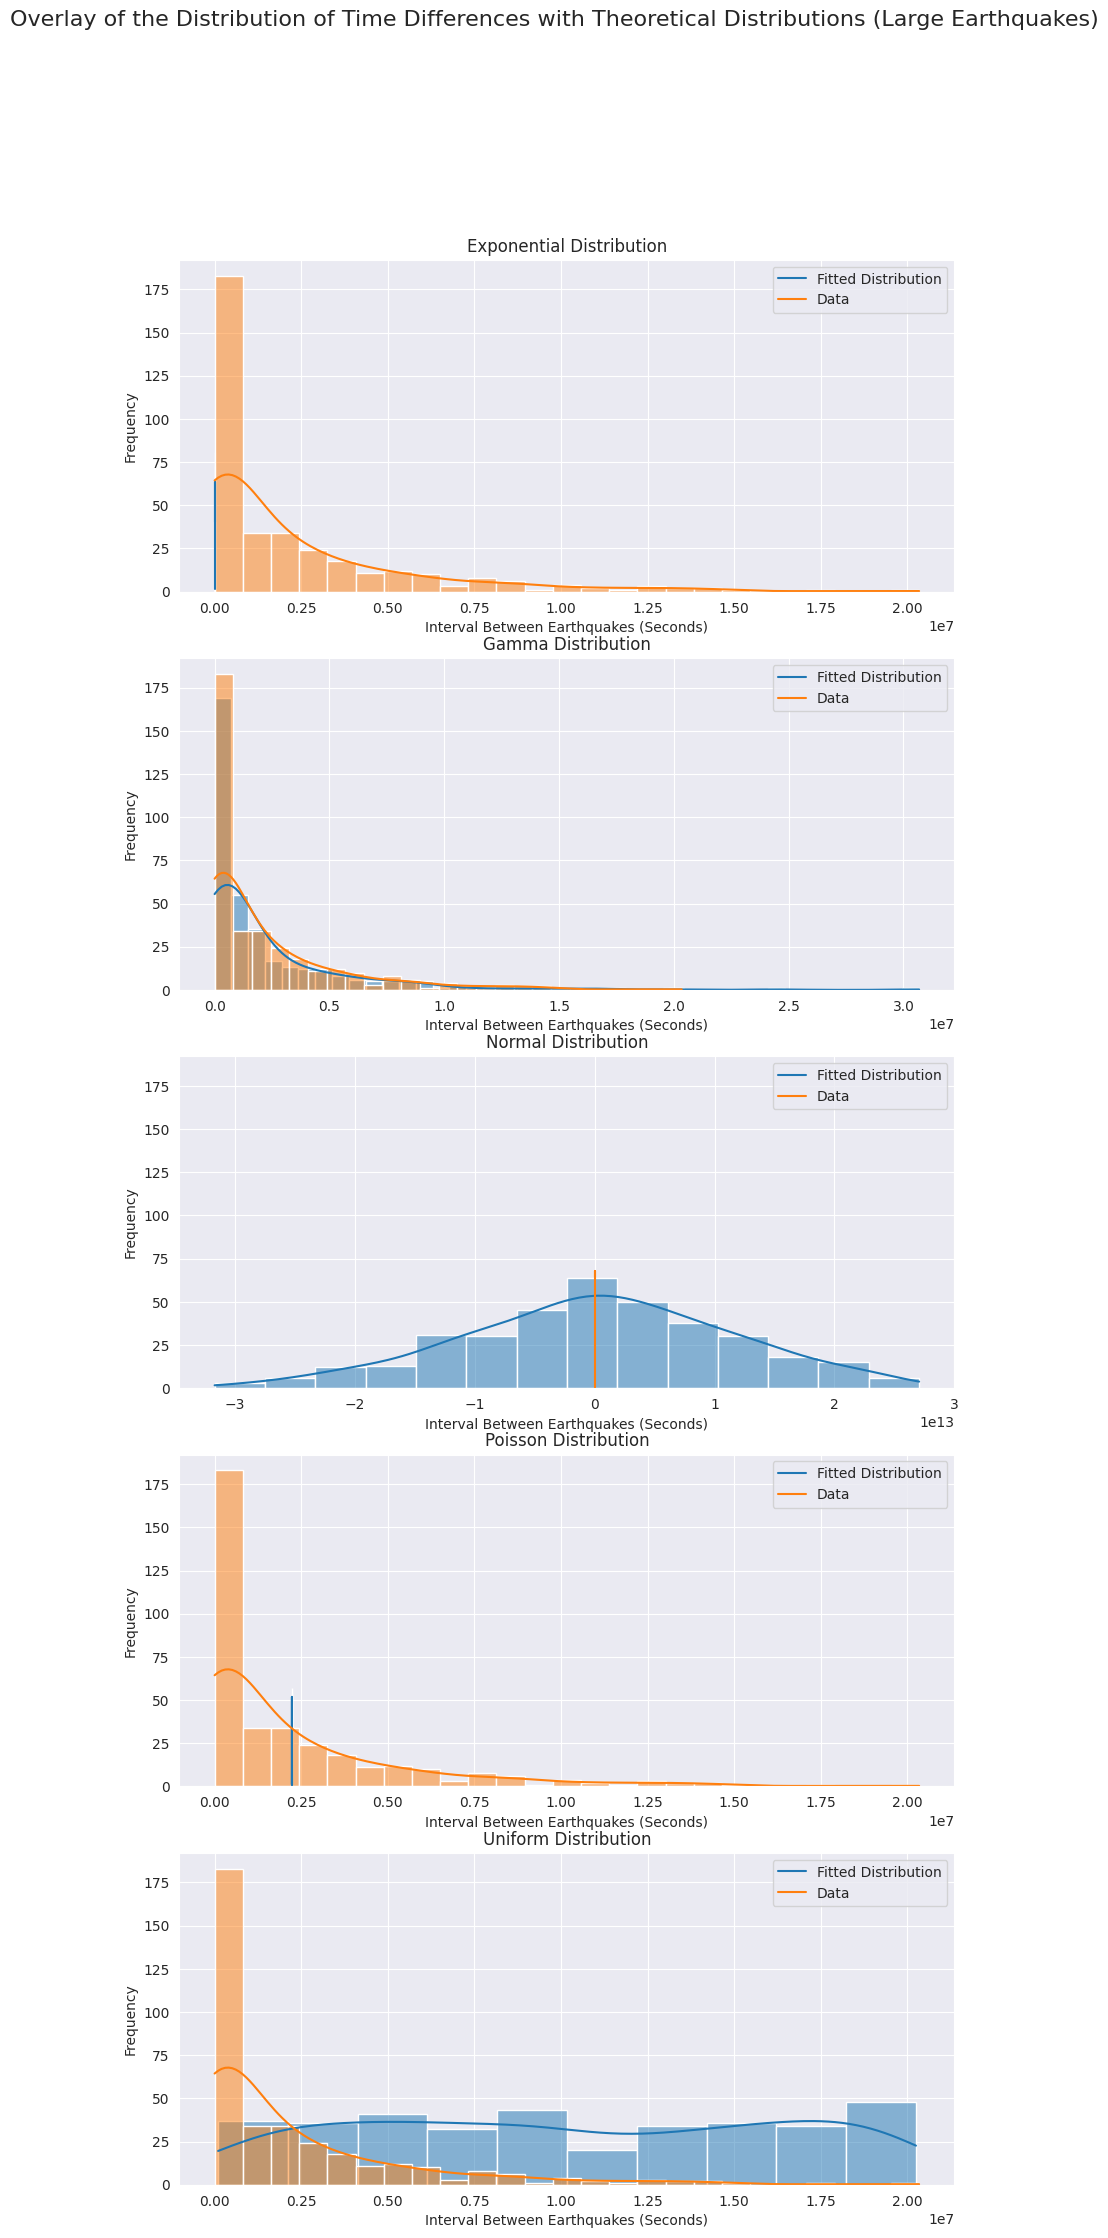

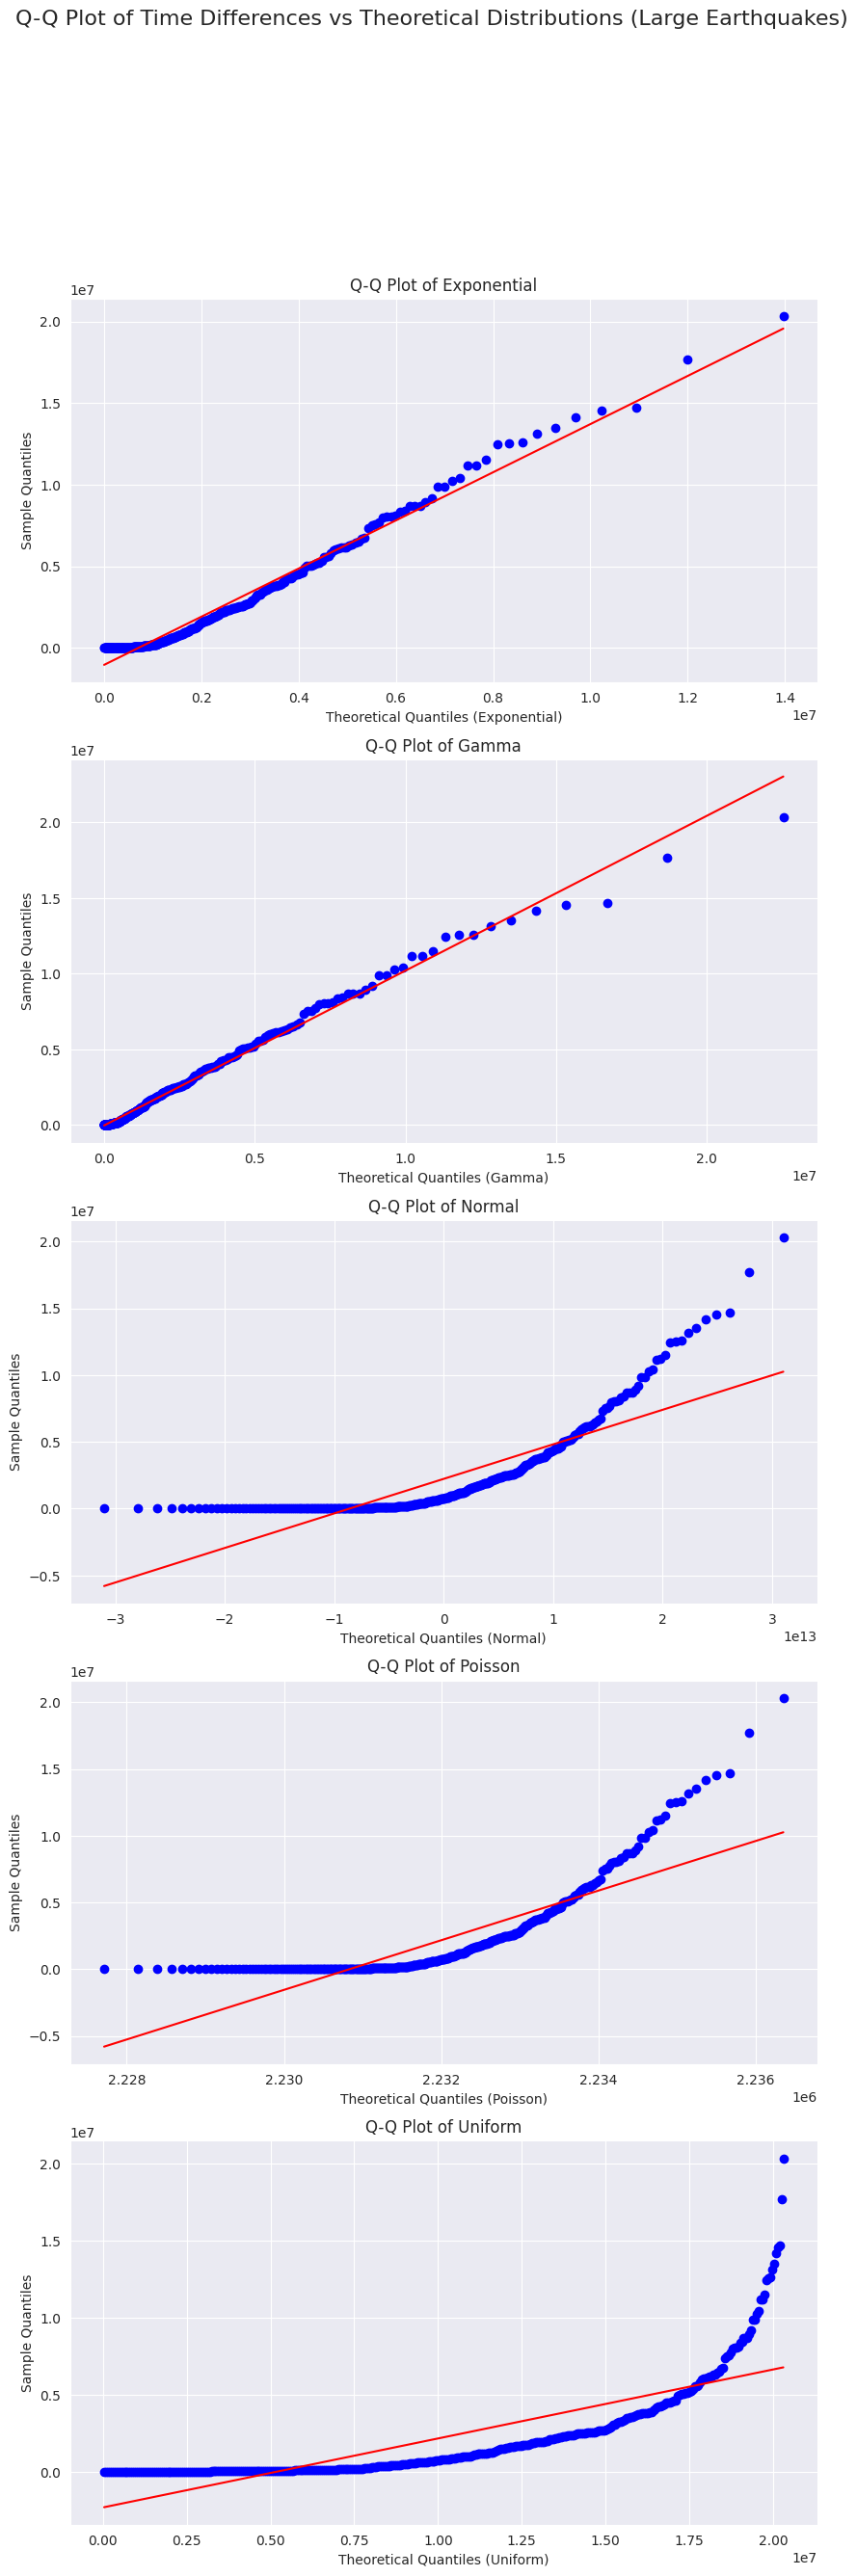

In [9]:

# Earthquakes with magnitude greater than 5
results_big_eq, params_big_eq = inter_arrival_time_analysis(df, "Large")
# 

/tmp/ipykernel_26834/1496985046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_datetime(df["time"])


The best fit distribution for the time differences is Gamma Distribution with a p-value of 8.132343536672359e-16
The estimated parameters are: {'estimated_alpha': np.float64(0.4947715510271544), 'estimated_beta': np.float64(2.6616718343494354e-06)}


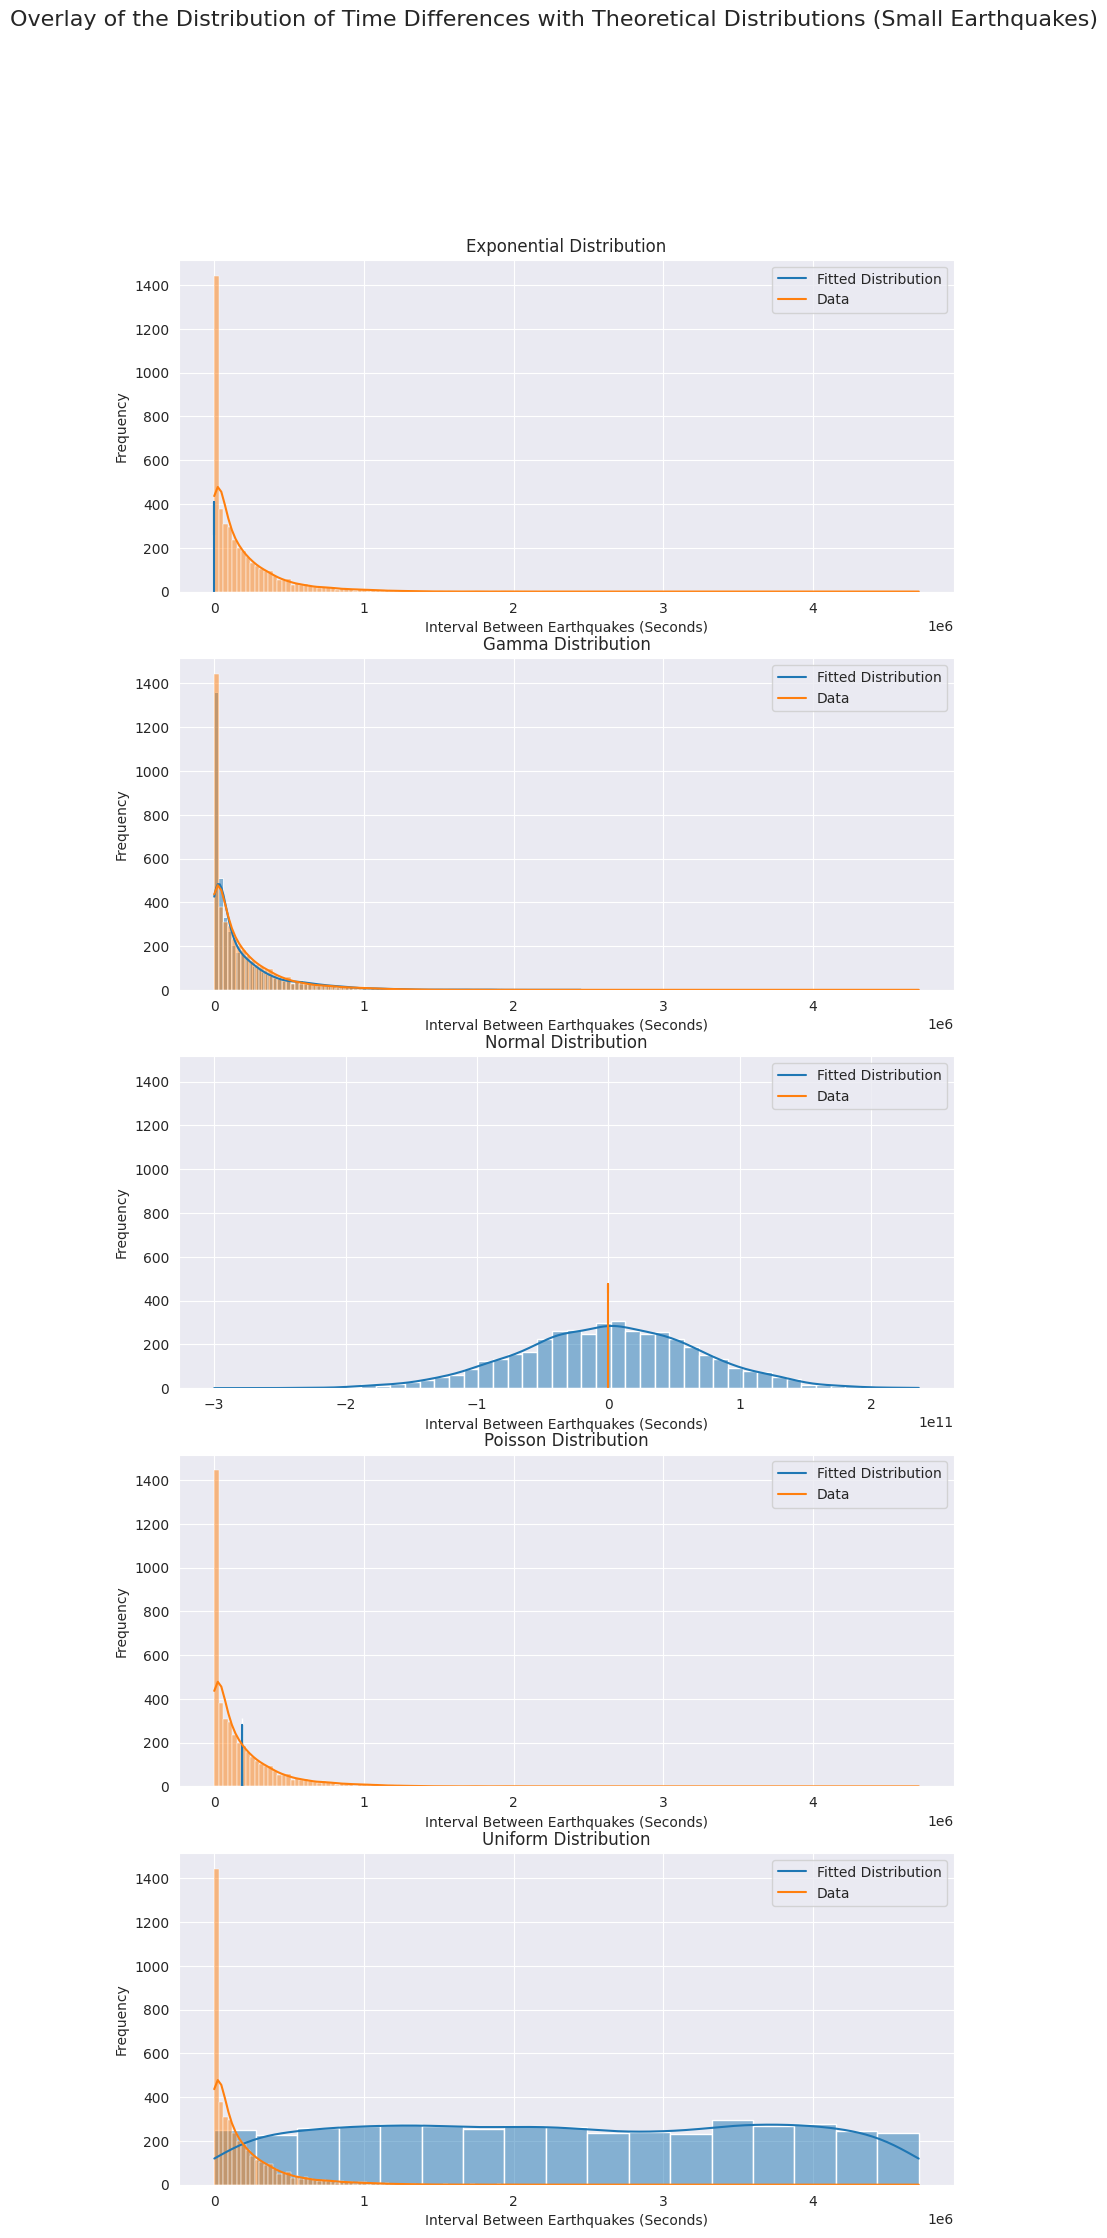

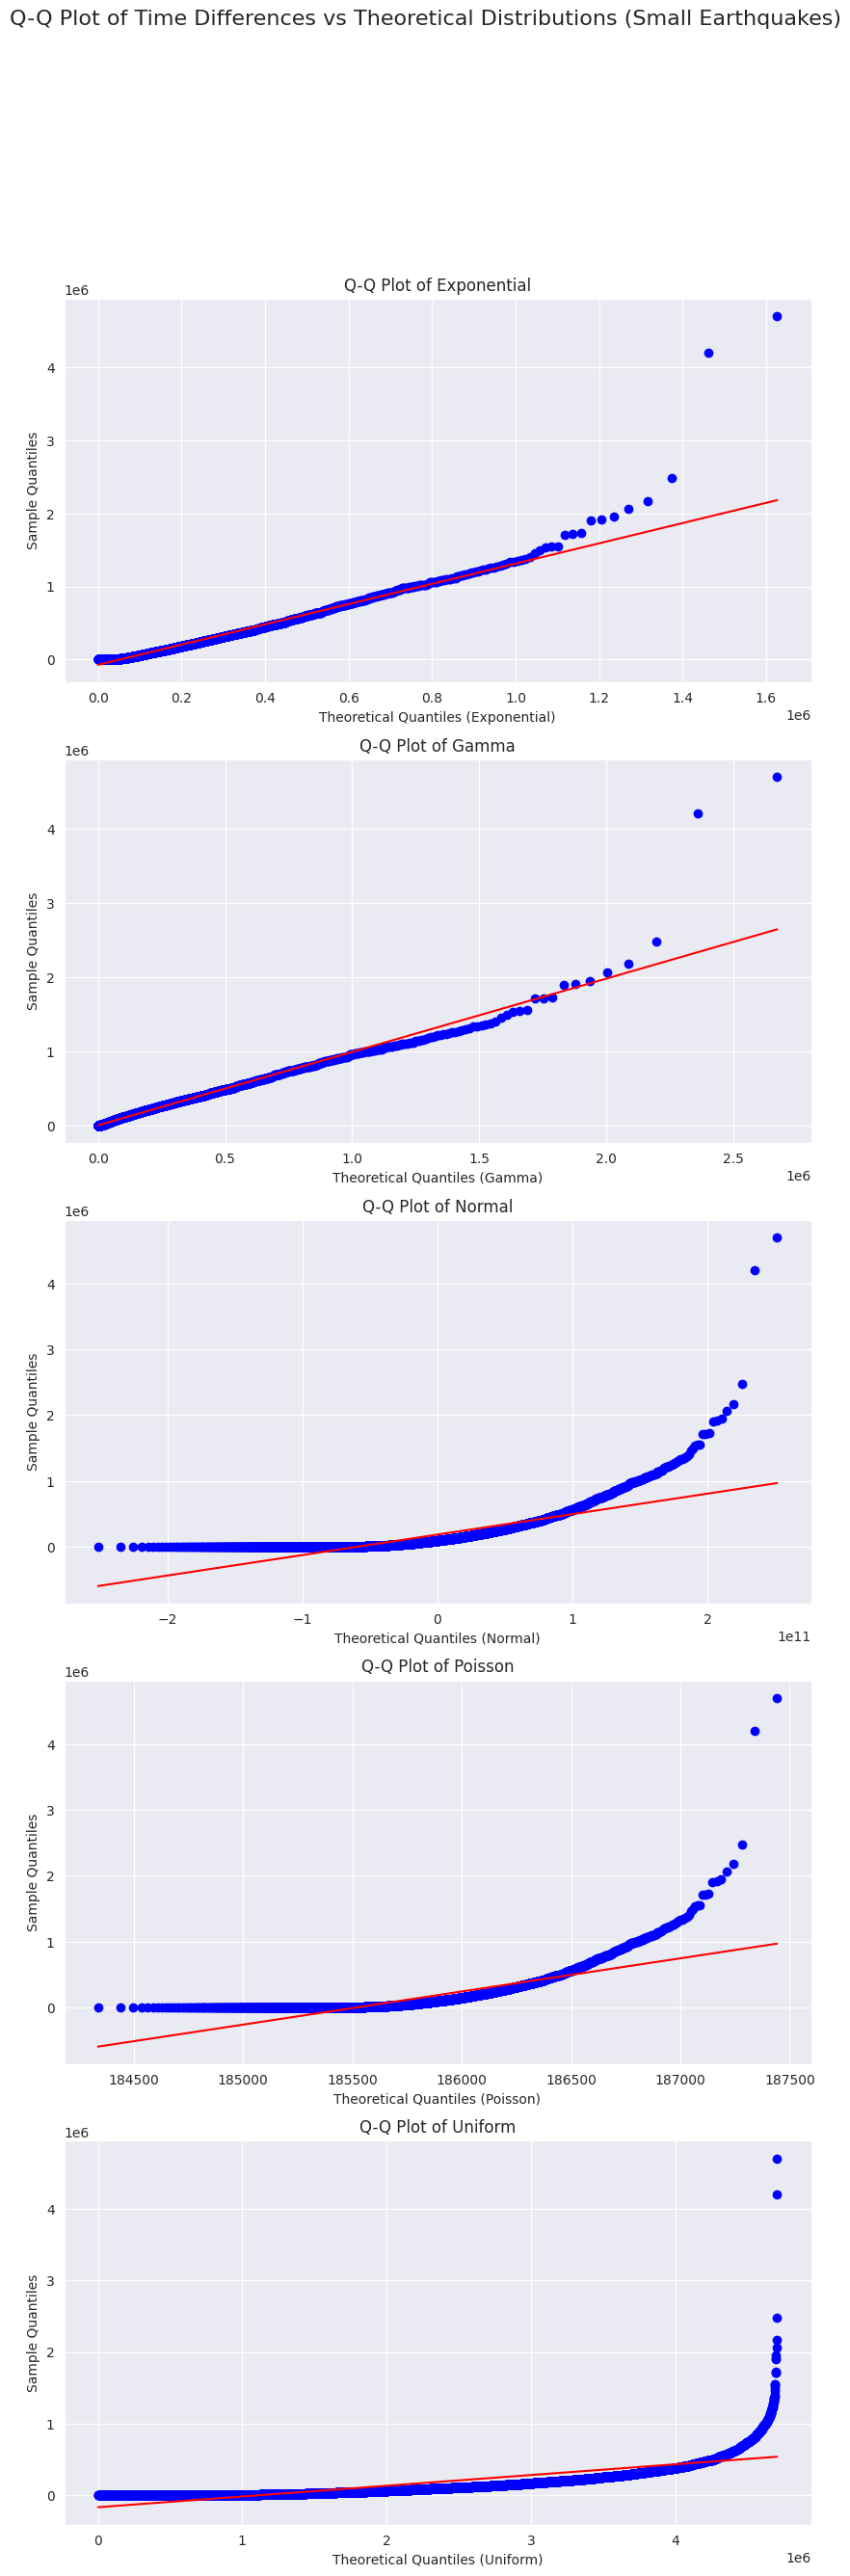

In [10]:

# Earthquakes with magnitude less than 5
results_sm_eq, params_sm_eq = inter_arrival_time_analysis(df, "Small")



The best fit distribution for the magnitude of the earthquakes is Gamma Distribution with a p-value of 1.6806179373296966e-41
The estimated parameters are: {'estimated_alpha': np.float64(85.03819936532432), 'estimated_beta': np.float64(19.34853937538075)}
The probability of a large earthquake occurring is 0.10545929954264188


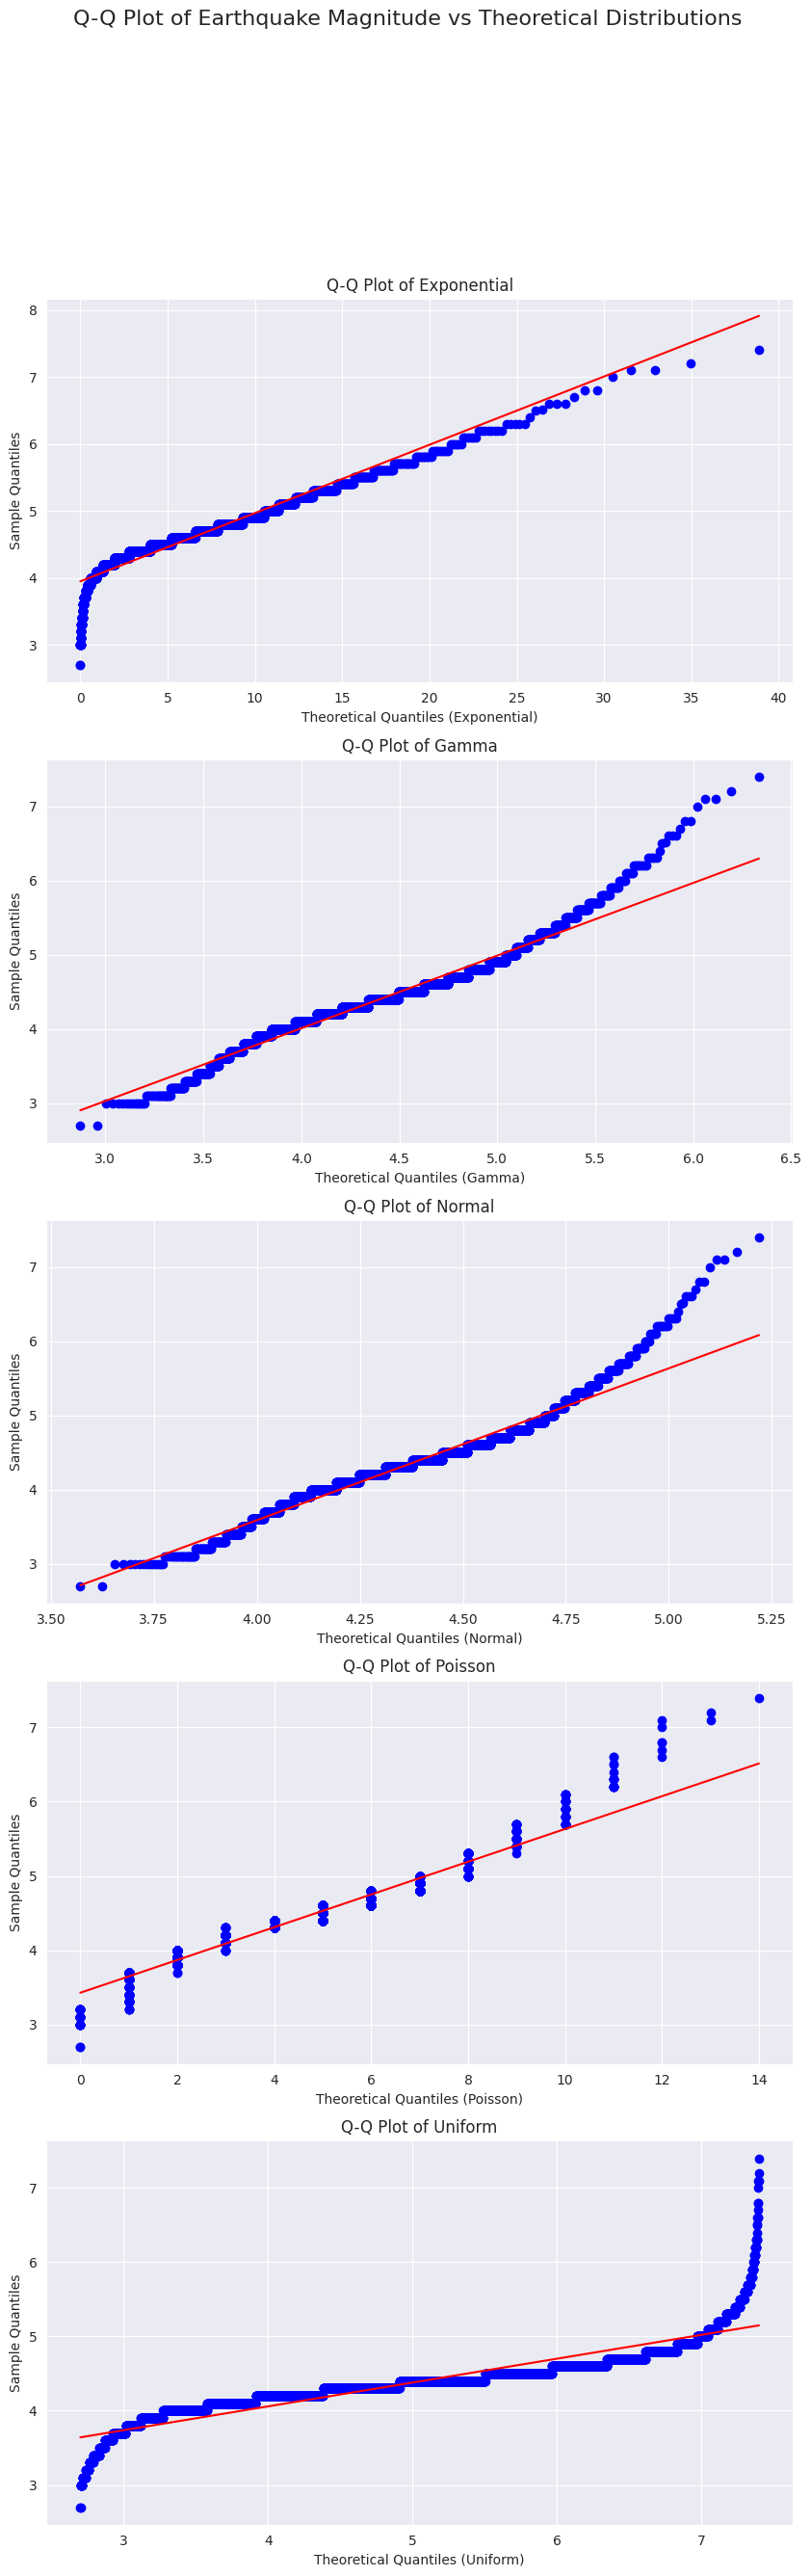

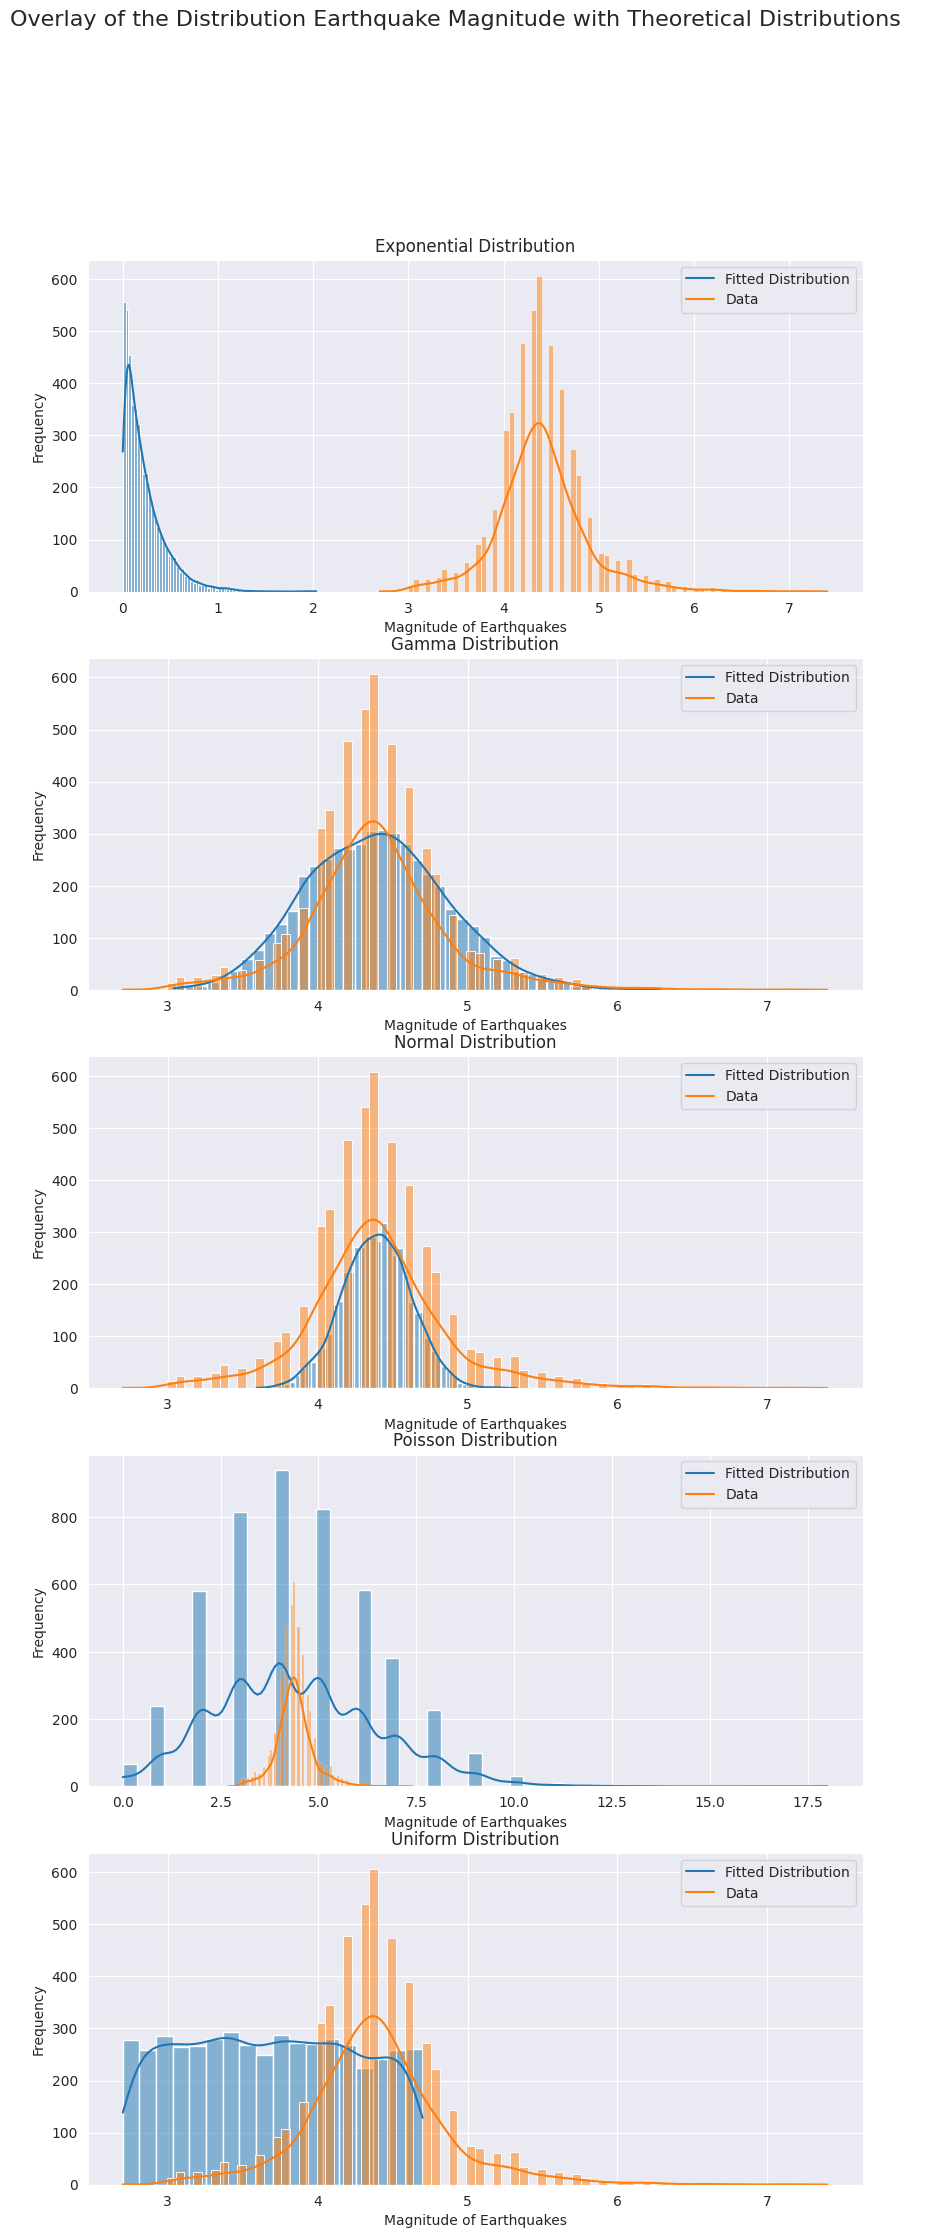

In [11]:

mag_dist_type, mag_dist_params = magnitude_analysis(df)

# Simulation

# Method 1

2024-10-20 16:38:00.093884: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Batch 0 of 2000 completed
Batch 1000 of 2000 completed


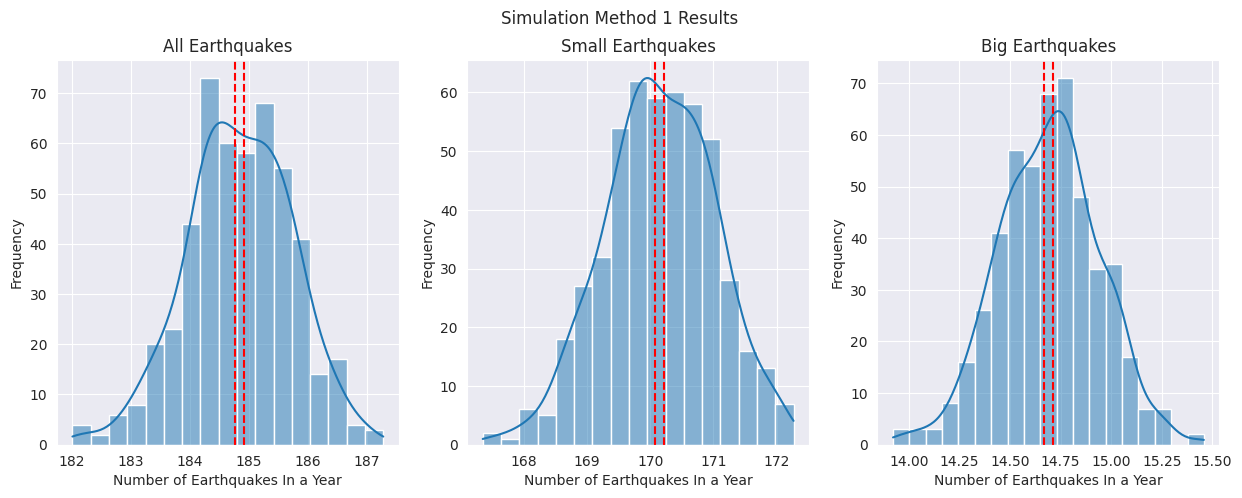

In [12]:
def m_1_sim(a, b, key):
    """
    Simulate the number of events occurring within a year using a Gamma distribution.

    :param a: Shape parameter of the Gamma distribution.
    :param b: Rate parameter of the Gamma distribution.
    :param key: PRNG key for JAX random number generation.
    :return: The number of events occurring within a year.
    """
    T = 365 * 24 * 60 * 60
    ns = random.gamma(key, a, shape=(300,))/b
    t = jnp.cumsum(ns)
    i = jnp.argmax(t > T)
    return i

@eqx.filter_jit
def m_1_experiment(a, b, keys, n_runs) -> jnp.ndarray:
    """
    Perform multiple simulations of the number of events occurring within a year.

    :param a: Shape parameter of the Gamma distribution.
    :param b: Rate parameter of the Gamma distribution.
    :param keys: PRNG keys for JAX random number generation.
    :param n_runs: Number of simulation runs.
    :return: An array containing the number of events for each run.
    """
    keys = random.split(keys, n_runs)
    return jax.vmap(m_1_sim, in_axes=(None, None, 0))(a, b, keys)




def m_1_sim_small_and_big_eq(small_alpha, small_beta, big_alpha, big_beta,keys, n_runs) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Simulate the number of small and big earthquakes occurring within a year.

    :param small_alpha: Shape parameter for small earthquakes.
    :param small_beta: Rate parameter for small earthquakes.
    :param big_alpha: Shape parameter for big earthquakes.
    :param big_beta: Rate parameter for big earthquakes.
    :param keys: PRNG keys for JAX random number generation.
    :param n_runs: Number of simulation runs.
    :return: A tuple containing the mean number of small and big earthquakes.
    """

    key, subkey = random.split(keys)
    small_eq = m_1_experiment(small_alpha, small_beta, subkey, n_runs)
    key, subkey = random.split(key)
    big_eq = m_1_experiment(big_alpha, big_beta,subkey, n_runs)
    return jnp.mean(small_eq), jnp.mean(big_eq)
    
    
    
    
def m_1_batched_simulate_data(params_small, params_big, n_runs, n_exps, batch_size) -> Tuple[Array, Array, Array]:
    """
    Perform batched simulations of small and big earthquakes and aggregate the results.

    :param params_small: Parameters for the small earthquakes' Gamma distribution.
    :param params_big: Parameters for the big earthquakes' Gamma distribution.
    :param n_runs: Number of simulation runs.
    :param n_exps: Number of experiments per run.
    :param batch_size: Size of each batch for simulation.
    :return: A tuple containing arrays of small, big, and total earthquake counts.
    """

    key = random.PRNGKey(42)
    key, subkey = random.split(key)
    sum_keys = random.split(subkey, n_exps)
    
    results_small = []
    results_big = []
    results_sum = []
    
    for i in range(0, n_runs, batch_size):
        small, big  = jax.vmap(m_1_sim_small_and_big_eq, in_axes=(None, None, None, None, 0, None))(params_small["estimated_alpha"], params_small["estimated_beta"], params_big["estimated_alpha"], params_big["estimated_beta"], sum_keys[i:i+batch_size], n_exps)
        
        
        results_small.append(small)
        results_big.append(big)
        sum_runs = small + big
        results_sum.append(sum_runs)

    
        if i % 1000 == 0:
            print(f"Batch {i} of {n_runs} completed")
        

    return jnp.concatenate(results_small), jnp.concatenate(results_big), jnp.concatenate(results_sum)


m1_s, m1_b, m1_t = m_1_batched_simulate_data(params_sm_eq["Gamma Distribution"], params_big_eq["Gamma Distribution"], n_runs=n_runs, n_exps=n_exps, batch_size=5)

plot_earthquake_data(m1_t, m1_s, m1_b, "Simulation Method 1 Results")


results_table["Method 1"] = {
    "All Earthquakes": calculate_summary(m1_t),
    "Small Earthquakes": calculate_summary(m1_s),
    "Big Earthquakes": calculate_summary(m1_b)
}


# Method 2


  0%|          | 0/200 [00:00<?, ?it/s]

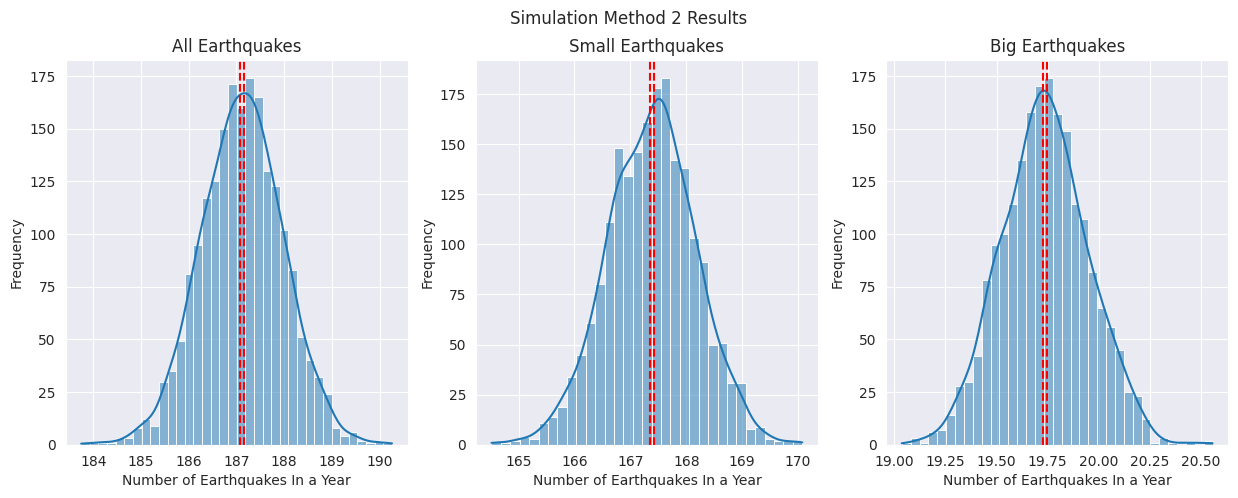

In [13]:

def simulate_magnitude_data(alpha, beta, n_eqs) -> int:
    """
    Simulate earthquake magnitudes using a Gamma distribution and count the number of small earthquakes.

    :param alpha: Shape parameter of the Gamma distribution.
    :param beta: Rate parameter of the Gamma distribution.
    :param n_eqs: Number of earthquakes to simulate.
    :return: The number of earthquakes with magnitude less than 5.
    """

    magnitude_data = np.random.gamma(alpha, 1/beta, n_eqs)
    return np.sum(magnitude_data < 5)

def m_2_experiment(a, b, n_runs) -> np.ndarray:
    """
    Simulate the number of events occurring within a year using a Gamma distribution for multiple runs.

    :param a: Shape parameter of the Gamma distribution.
    :param b: Rate parameter of the Gamma distribution.
    :param n_runs: Number of simulation runs.
    :return: An array containing the number of events for each run.
    """
    results = []
    for _ in range(n_runs):
        T = 365 * 24 * 60 * 60
        ns = np.random.gamma(a, 1/b, 300)
        t = np.cumsum(ns)
        i = np.argmax(t > T)
        results.append(i)
    return np.array(results)

def m_2_batched_simulate_data_and_mag(all_params, mag_params, n_runs, n_exps, batch_size) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform batched simulations of earthquake events and magnitudes, and aggregate the results.

    :param all_params: Parameters for the Gamma distribution of all earthquakes.
    :param mag_params: Parameters for the Gamma distribution of earthquake magnitudes.
    :param n_runs: Number of simulation runs.
    :param n_exps: Number of experiments per run.
    :param batch_size: Size of each batch for simulation.
    :return: A tuple containing arrays of total earthquake counts and small earthquake counts.
    """
    results = []
    small_count = []

    foo = lambda x: simulate_magnitude_data(mag_params["estimated_alpha"], mag_params["estimated_beta"], x)

    for i in tqdm(range(0, n_runs, batch_size)):
        all_runs = [m_2_experiment(all_params["estimated_alpha"], all_params["estimated_beta"], n_exps) for _ in range(batch_size)]

        all_small = []
        for run in all_runs:
            small = [foo(x) for x in run]
            all_small.append(small)

        all_small = np.array(all_small)
        small_mean = np.mean(all_small, axis=1)
        all_mean = np.mean(all_runs, axis=1)

        results.append(all_mean)
        small_count.append(small_mean)
        

    return np.concatenate(results), np.concatenate(small_count)



m2_t, m2_s = m_2_batched_simulate_data_and_mag(params_all_eq["Gamma Distribution"], mag_dist_params, n_runs, n_exps, 10)
m2_b = m2_t - m2_s
plot_earthquake_data(m2_t, m2_s, m2_b, "Simulation Method 2 Results")

results_table["Method 2"] = {
    "All Earthquakes": calculate_summary(m2_t),
    "Small Earthquakes": calculate_summary(m2_s),
    "Big Earthquakes": calculate_summary(m2_b)
}


# Sensitivity analysis


# Method 1

In [15]:
def sample_from_actually_observed_data(data:pd.DataFrame, n_samples:int) -> pd.DataFrame:
    """
    Sample from the actually observed data.
    
    :param data: A pandas DataFrame of the observed data.
    :param n_samples: An integer representing the number of samples to draw.
    :return: A pandas DataFrame of the sampled data.
    """
    return data.sample(n_samples, replace=True)


/tmp/ipykernel_26834/1496985046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_datetime(df["time"])
/tmp/ipykernel_26834/1496985046.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_datetime(df["time"])


  0%|          | 0/2000 [00:00<?, ?it/s]

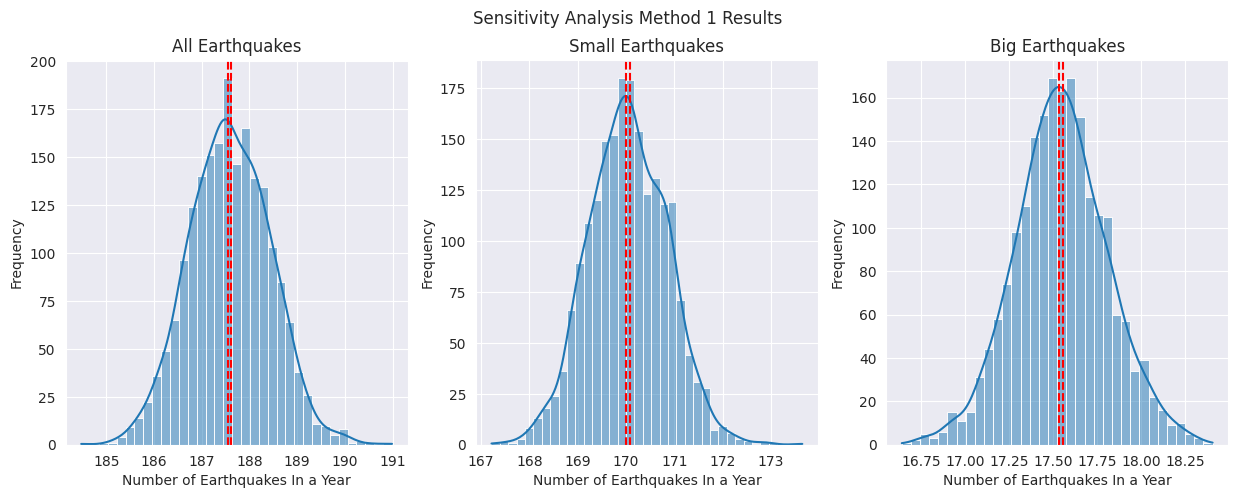

In [16]:



def method_1_sensitivity_experiment(df_small, df_big, n_exps):
    """
    Perform a sensitivity analysis by sampling from the observed data and simulating the number of earthquakes.
    :param df_small: dataframe of small earthquakes
    :param df_big: dataframe of big earthquakes
    :param n_exps: number of experiments
    :return: average number of small and big earthquakes in a year
    """
    year_in_seconds = 365 * 24 * 60 * 60
    small_res = np.zeros(n_exps)
    big_res = np.zeros(n_exps)

    for i in range(n_exps):
        small_sample = sample_from_actually_observed_data(df_small, 210)
        big_sample = sample_from_actually_observed_data(df_big, 200)

        small_cum_time = np.cumsum(small_sample["time"].values)
        big_cum_time = np.cumsum(big_sample["time"].values)

        small_res[i] = np.sum(small_cum_time < year_in_seconds)
        big_res[i] = np.sum(big_cum_time < year_in_seconds)

    return np.mean(small_res), np.mean(big_res)


def method_1_sensitivity_analysis(data, n_runs=1000, n_exps=1000):
    """
    Perform a sensitivity analysis over multiple runs.
    :param data: earthquake data
    :param n_runs: number of runs
    :param n_exps: number of experiments per run
    :return: 
    """
    df_small = data[data["mag"] < 5]
    df_big = data[data["mag"] >= 5]

    df_small = process_time(df_small)
    df_big = process_time(df_big)

    small_res = np.zeros(n_runs)
    big_res = np.zeros(n_runs)

    for i in tqdm(range(n_runs)):
        small_res[i], big_res[i] = method_1_sensitivity_experiment(df_small, df_big, n_exps)

    return small_res, big_res


sm_m1_s, sm_m1_b = method_1_sensitivity_analysis(df, n_runs=n_runs, n_exps=n_exps)
sm_m1_t = sm_m1_s + sm_m1_b

results_table["Method 1 Sensitivity"] = {
    "All Earthquakes": calculate_summary(sm_m1_t),
    "Small Earthquakes": calculate_summary(sm_m1_s),
    "Big Earthquakes": calculate_summary(sm_m1_b)
}
plot_earthquake_data(sm_m1_t, sm_m1_s, sm_m1_b, "Sensitivity Analysis Method 1 Results")

# Method 2

  0%|          | 0/2000 [00:00<?, ?it/s]

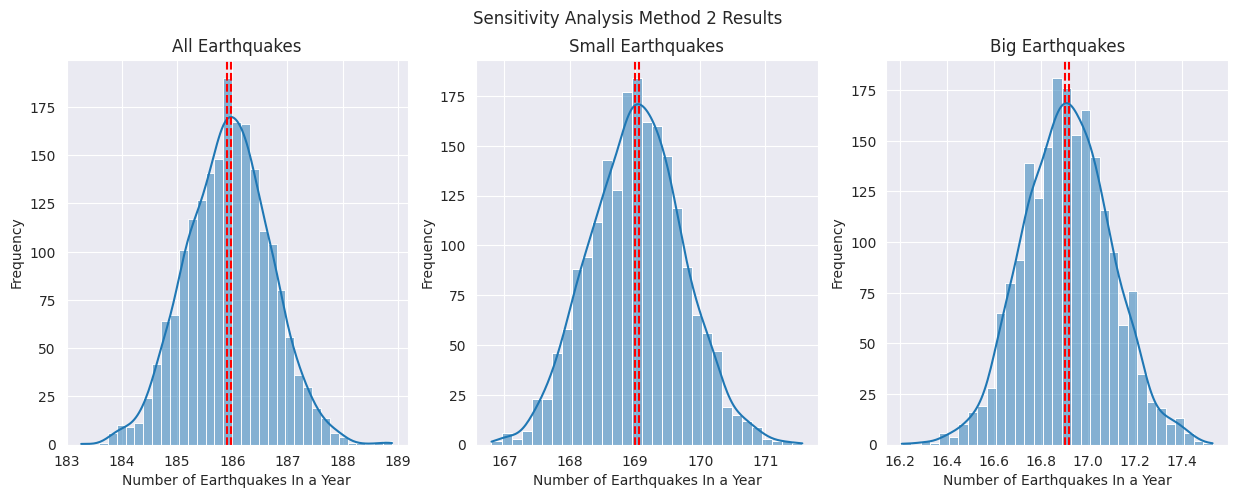

In [17]:


def method_2_sensitivity_experiment(data: pd.DataFrame, n_exps: int) -> Tuple[float, float]:
    """
    Perform a sensitivity analysis by sampling from the observed data and simulating the number of earthquakes.

    :param data: A pandas DataFrame of the observed data.
    :param n_exps: An integer representing the number of experiments.
    :return: A tuple of the mean number of small and big earthquakes.
    """
    year_in_seconds = 365 * 24 * 60 * 60
    small_res = np.zeros(n_exps)
    big_res = np.zeros(n_exps)

    for i in range(n_exps):
        samp = sample_from_actually_observed_data(data, 210)
        cumulative_time = np.cumsum(samp["time"].values)
        mags = samp["mag"].values
        small_res[i] = np.sum(mags[cumulative_time < year_in_seconds] < 5)
        big_res[i] = np.sum(mags[cumulative_time < year_in_seconds] >= 5)

    return np.mean(small_res), np.mean(big_res)

def method_2_sensitivity_analysis(data: pd.DataFrame, n_runs: int = 1000, n_exps: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform a sensitivity analysis over multiple runs.

    :param data: A pandas DataFrame of the observed data.
    :param n_runs: An integer representing the number of runs.
    :param n_exps: An integer representing the number of experiments per run.
    :return: Two numpy arrays containing the results of small and big earthquakes.
    """
    data = process_time(data)
    
    small_res = np.zeros(n_runs)
    big_res = np.zeros(n_runs)

    for i in tqdm(range(n_runs)):
        small_res[i], big_res[i] = method_2_sensitivity_experiment(data, n_exps)

    return small_res, big_res


sm_m2_s, sm_m2_b = method_2_sensitivity_analysis(df, n_runs=n_runs, n_exps=n_exps)
sm_m2_t = sm_m2_s + sm_m2_b

results_table["Method 2 Sensitivity"] = {
    "All Earthquakes": calculate_summary(sm_m2_t),
    "Small Earthquakes": calculate_summary(sm_m2_s),
    "Big Earthquakes": calculate_summary(sm_m2_b)
}
plot_earthquake_data(sm_m2_t, sm_m2_s, sm_m2_b, "Sensitivity Analysis Method 2 Results")



In [18]:
pprint(results_table)

{'Method 1': {'All Earthquakes': {'CI_lower': Array(184.76306, dtype=float32),
                                  'CI_upper': Array(184.91922, dtype=float32),
                                  'mean': Array(184.84114, dtype=float32),
                                  'std': Array(0.89080137, dtype=float32)},
              'Big Earthquakes': {'CI_lower': Array(14.670481, dtype=float32),
                                  'CI_upper': Array(14.713778, dtype=float32),
                                  'mean': Array(14.692129, dtype=float32),
                                  'std': Array(0.24697877, dtype=float32)},
              'Small Earthquakes': {'CI_lower': Array(170.07315, dtype=float32),
                                    'CI_upper': Array(170.22488, dtype=float32),
                                    'mean': Array(170.14902, dtype=float32),
                                    'std': Array(0.86554605, dtype=float32)}},
 'Method 1 Sensitivity': {'All Earthquakes': {'CI_lower': Array(

In [20]:
def format_to_latex_table(data: dict) -> str:
    """
    Format the input data into a LaTeX table.

    :param data: A dictionary containing the data to be formatted.
    :return: A string representing the LaTeX table.
    """
    header = r"""
\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Method & Earthquake Type & Mean & Std & CI (Lower, Upper) \\
\hline
"""
    footer = r"""
\hline
\end{tabular}
\caption{Summary statistics of earthquake simulations.}
\label{tab:earthquake_summary}
\end{table}
"""
    rows = []
    for method, types in data.items():
        for eq_type, stats in types.items():
            mean = stats['mean'].item()
            std = stats['std'].item()
            ci_lower = stats['CI_lower'].item()
            ci_upper = stats['CI_upper'].item()
            row = f"{method} & {eq_type} & {mean:.2f} & {std:.2f} & ({ci_lower:.2f}, {ci_upper:.2f}) \\\\"
            rows.append(row)
    
    table_content = "\n".join(rows)
    latex_table = header + table_content + footer
    return latex_table



latex_table = format_to_latex_table(results_table)
print(latex_table)


\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Method & Earthquake Type & Mean & Std & CI (Lower, Upper) \\
\hline
Method 1 & All Earthquakes & 184.84 & 0.89 & (184.76, 184.92) \\
Method 1 & Small Earthquakes & 170.15 & 0.87 & (170.07, 170.22) \\
Method 1 & Big Earthquakes & 14.69 & 0.25 & (14.67, 14.71) \\
Method 2 & All Earthquakes & 187.12 & 0.86 & (187.08, 187.16) \\
Method 2 & Small Earthquakes & 167.38 & 0.79 & (167.35, 167.42) \\
Method 2 & Big Earthquakes & 19.74 & 0.21 & (19.73, 19.75) \\
Method 1 Sensitivity & All Earthquakes & 187.59 & 0.85 & (187.55, 187.62) \\
Method 1 Sensitivity & Small Earthquakes & 170.04 & 0.81 & (170.00, 170.07) \\
Method 1 Sensitivity & Big Earthquakes & 17.55 & 0.26 & (17.54, 17.56) \\
Method 2 Sensitivity & All Earthquakes & 185.94 & 0.76 & (185.90, 185.97) \\
Method 2 Sensitivity & Small Earthquakes & 169.03 & 0.71 & (168.99, 169.06) \\
Method 2 Sensitivity & Big Earthquakes & 16.91 & 0.19 & (16.90, 16.92) \\
\hline
\end{tabula